# Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

In [2]:
fs = 44100

fs_, x_prbs15 = scipy.io.wavfile.read("../app/sound/prbs15.wav")
assert(fs_ == fs)

fs_, x_prbs20 = scipy.io.wavfile.read("../app/sound/prbs20.wav")
assert(fs_ == fs)

In [3]:
FIG_WIDTH = 8
H_XLIM = [20, 20e3]
H_YLIM = [-50, 10]

def plot_frequency_response(b, a, ax=None, label=None):
    if ax is None:
        ax = gca()
        
    f, H = signal.freqz(b, a)
    f *= fs/2/pi
    ax.semilogx(f, 20*log10(abs(H)), label=label)

def prbs_analyze(x, y, fs, h_length):
    # Estimate impulse response using a pseudo-random bit sequence.
    h = signal.correlate(y, x, "full")
    h = h[len(h)//2:]
    
    # Limit the impulse response length to lower the noise
    h = h[0:h_length]
    t = arange(h_length)/fs

    # Estimate frequency response
    H = fft.fft(h)
    H = H[0:len(H)//2] 
    H /= max(abs(H))
    f = linspace(0.01, fs/2, len(H))
    
    return t, h, f, H

def show_impulse_response(t, h, ax=None, label=None):
    if ax is None:
        ax = gca()

    ax.plot(t, real(h), label=label)
    ax.grid(True)
    ax.legend()

def show_frequency_response(f, H, ax=None, label=None):
    if ax is None:
        ax = gca()

    ax.semilogx(f, 20*log10(abs(H)), label=label)
    
    ax.grid(True, "both", "both")
    ax.legend()
    ax.set_xlim(*H_XLIM)
    ax.set_ylim(*H_YLIM)

/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:492: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


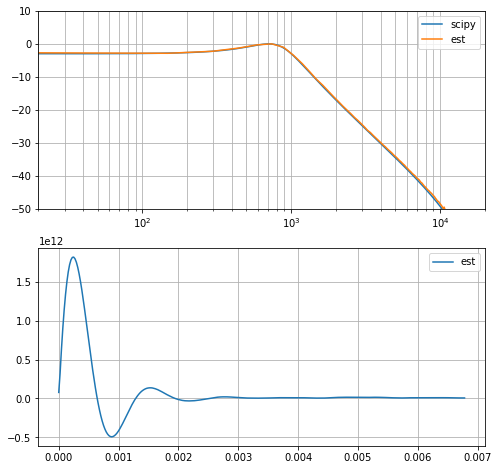

In [4]:
# Example filter
fig, (ax1, ax2) = subplots(2, 1, figsize=[FIG_WIDTH, 8])

# Analyzing coefficients with Scipy
b, a = signal.cheby1(2, 3, 1000 * 2/fs, btype="low")
plot_frequency_response(b, a, ax=ax1, label="scipy")

# Analyzing the filter with a PRBS measurement
y = signal.lfilter(b, a, x_prbs15)
t, h, f, H = prbs_analyze(x_prbs15, y, fs, 300)

show_frequency_response(f, H, ax=ax1, label="est")
show_impulse_response(t, h, ax=ax2, label="est")

# Zavalishin 2015 The Art of VA Filter Design

Ladder filter:
- Four single-pole filter, page 48.
- Feedback, page 63.

In [5]:
def ladder_zavalishin(x, g, k):
    y = zeros(len(x))
    G = g/(1+g)

    w1 = [0, 0, 0, 0] # Delayed sum of y[n] and x[n]*G
    y1 = 0 # Delayed output
    for n in range(1, len(y)):
        u = x[n] - y1*k

        # 1
        x_ = u
        v  = (x_-w1[0]) * G
        y_ = v + w1[0]
        w1[0] = y_ + v

        # 2
        x_ = y_
        v  = (x_-w1[1]) * G
        y_ = v + w1[1]
        w1[1] = y_ + v

        # 3
        x_ = y_
        v  = (x_-w1[2]) * G
        y_ = v + w1[2]
        w1[2] = y_ + v

        # 3
        x_ = y_
        v  = (x_-w1[3]) * G
        y_ = v + w1[3]
        w1[3] = y_ + v

        y[n] = y_
        y1 = y_

    return y

def run(x, g, k, h_length, fig, ax1, ax2):    
    y = ladder_zavalishin(x, g=g, k=k)
    
    t, h, f, H = prbs_analyze(x, y, fs, h_length)
    label = "g={:.03f}, k={:.2f}".format(g, k)
    show_frequency_response(f, H, ax=ax1, label=label)
    show_impulse_response(t, h, ax=ax2, label=label)

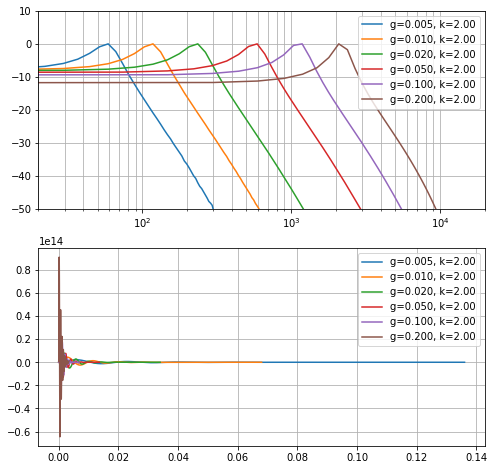

In [6]:
# Sweep cutoff
fig, (ax1, ax2) = subplots(2, 1, figsize=[FIG_WIDTH, 8])
k = 2
for g in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]:
    h_length = int(30/g)
    run(x_prbs20, g, k, h_length, fig, ax1, ax2)

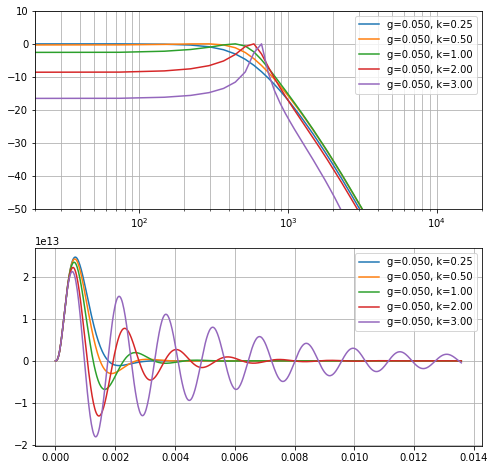

In [7]:
# Sweep resonance
fig, (ax1, ax2) = subplots(2, 1, figsize=[FIG_WIDTH, 8])
g = 0.05
h_length = int(30/g)

for k in [0.25, 0.5, 1, 2, 3]:
    run(x_prbs20, g, k, h_length, fig, ax1, ax2)